preprocess for 1D CNN & AUTOENCODER

1) Load data
2) Split data 50:50 for (training+val; 80:20) & testing
3) get mean + std and scale datasets
4) Save processed data to be used in training 1D CNN and AutoEncoder

In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
#!{sys.executable} -m pip install tensorflow-gpu==2.4
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/vlian/anaconda3/envs/d|une-1dcnn/lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

'export' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from tqdm import trange

In [3]:
wireplane = "Z"
sig_name = wireplane+"-signal"
cln_name = wireplane+"-clnsig"
np.random.seed(42)
nticks = 200
max_mels = 11000
min_edp = 50000
ADC_MIN = 3
ADC_MAX = 10
waveform_scaler = StandardScaler()

def extract_wave(data):
    string = 'tck_'
    waveforms = []
    #Here I extract a column in each iteration and append to list
    for i in range(nticks):
        waveforms.append(data[string+str(i)].astype(np.int16))
    #convert to numpy ndarray
    waveforms = np.array(waveforms).astype(np.int16)
    #since raws and columns are inverted we need to transpose it
    return np.transpose(waveforms)

def extract_peak(data):
    #extract index of peak
    idx = np.array([data['stp0'], data['adc0'], data['stp1'], data['adc1'], data['stp2'], data['adc2'], data['stp3'], data['adc3'], data['stp4'], data['adc4']])
    #same as before
    return np.transpose(idx)

def extract_peak_info(data):
    peaks_pos = [data['stp0'], data['stp1'], data['stp2'], data['stp3'], data['stp4']]
    adcs = [data['adc0'], data['adc1'], data['adc2'], data['adc3'], data['adc4']]
    return np.array(peaks_pos).T, np.array(adcs).T

def extract_nel_info(data):
    nels = [data['nel0'], data['nel1'], data['nel2'], data['nel3'], data['nel4']]
    return np.array(nels).T

def extract_edp_info(data):
    edp = [data['edp0'], data['edp1'], data['edp2'], data['edp3'], data['edp4']]
    return np.array(edp).T

def filter_signals(data, clean_data, filter_adc_max=True):
    #edp_mask = np.all(extract_edp_info(data)>min_edp, axis = 1)
    #nel_mask = np.all(extract_nel_info(data)<max_mels, axis = 1)
    #pd.DataFrame(np.all(extract_edp_info(data)>min_edp, axis = 1)).describe()
    #print(edp_mask)
    #print(nel_mask)
    #filter_mask = nel_mask #np.logical_and(edp_mask,nel_mask) 
    filtered_data = data#[filter_mask]
    cln_filtered_data = clean_data#[filter_mask]
    
    filtered_peak = extract_peak_info(filtered_data)[1]
    if filter_adc_max:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
        peak_mask &= np.any(filtered_peak<ADC_MAX, axis = 1)
    else:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
    
    filtered_data = filtered_data[peak_mask]
    cln_filtered_data = cln_filtered_data[peak_mask]
    
    return filtered_data, cln_filtered_data, filtered_peak

def get_std_waveforms(data):
    #Extract and scale waveform data (passthrough rn)
    raw_waveforms = extract_wave(data)
    #print(raw_waveforms) 
    #scaled_waveforms = waveform_scaler.fit_transform(raw_waveforms)
    return raw_waveforms

In [4]:
#Load Training Data
#path = "../../dunesnb/1dcnn/train/train/nu_cc/"
#path2 = "../../dunesnb/1dcnn/train/train/nu_es/"

# NEW DATA SET WITH
path_cc = "../../Workspace/new_data/train_v1/nu_cc/"
path_es = "../../Workspace/new_data/train_v1/nu_es/"

filenames1 = [path_cc+f for f in listdir(path_cc) if (isfile(join(path_cc, f)) and sig_name in f)]
clean_filenames1 = [path_cc+f for f in listdir(path_cc) if (isfile(join(path_cc, f)) and cln_name in f)]
filenames2 = [path_es+f for f in listdir(path_es) if (isfile(join(path_es, f)) and sig_name in f)]
clean_filenames2 = [path_es+f for f in listdir(path_es) if (isfile(join(path_es, f)) and cln_name in f)]

filenames =  filenames1+filenames2
clean_filenames = clean_filenames1+clean_filenames2

combined_data = np.concatenate([np.load(fname) for fname in filenames])
combined_clean_data = np.concatenate([np.load(fname) for fname in clean_filenames])

noise_path = "../../Workspace/new_data/train_v1/noise/"
noise_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and wireplane in f)]
print(len(noise_filenames))

combined_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_filenames])
print(len(combined_noise))

50
100000


In [5]:
from sklearn.utils import shuffle
print(combined_data.shape[0])
#Filter out tiny signals < ADC_MIN, but leave big signals to test on (incl > ADC_MAX)
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, False)
print(combined_data.shape[0])

#split train and test sets (~50k ea before filtering) 
combined_data, x_test_data, combined_clean_data, x_test_clean  = train_test_split(
    combined_data, combined_clean_data, test_size=0.5, shuffle=True
)
print(combined_data.shape[0])
#filter data and extract waveforms of filtered data
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, True)
signal_waveforms = get_std_waveforms(combined_data)
clean_signal_waveforms = get_std_waveforms(combined_clean_data)  # for autoencoder
print(combined_data.shape[0])
#extract waveforms of noise
noise_waveforms = get_std_waveforms(combined_noise)
noiseless_waveform = noise_waveforms*0 # for autoencoder

#extract waveforms of test data
test_signal_waveforms = get_std_waveforms(x_test_data)
test_clean_waveforms = get_std_waveforms(x_test_clean)  # for autoencoder
print(test_signal_waveforms.shape[0], test_clean_waveforms.shape[0])


223385
140227
70113
69749
70114 70114


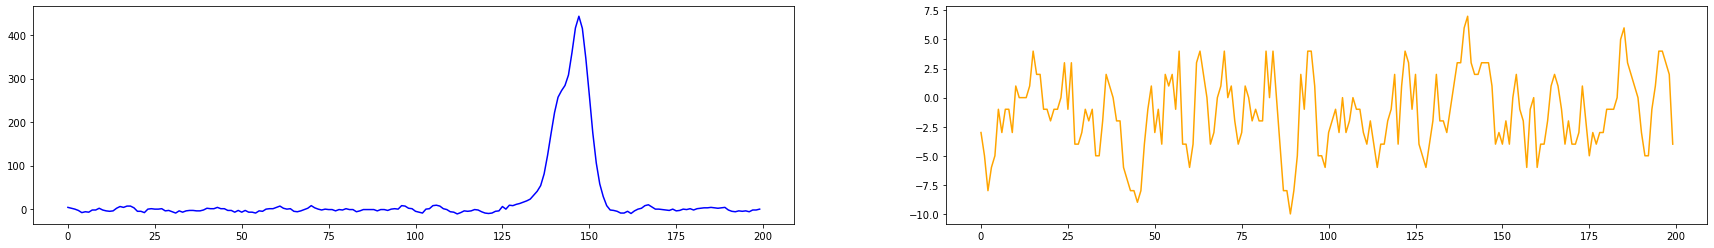

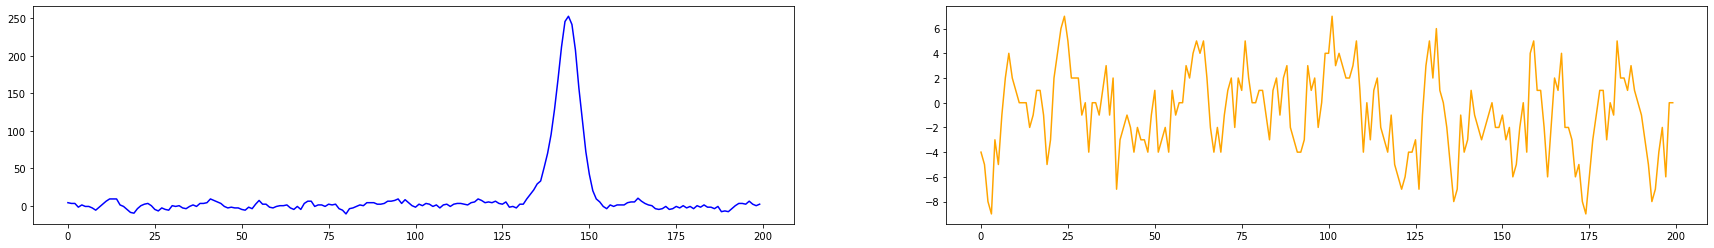

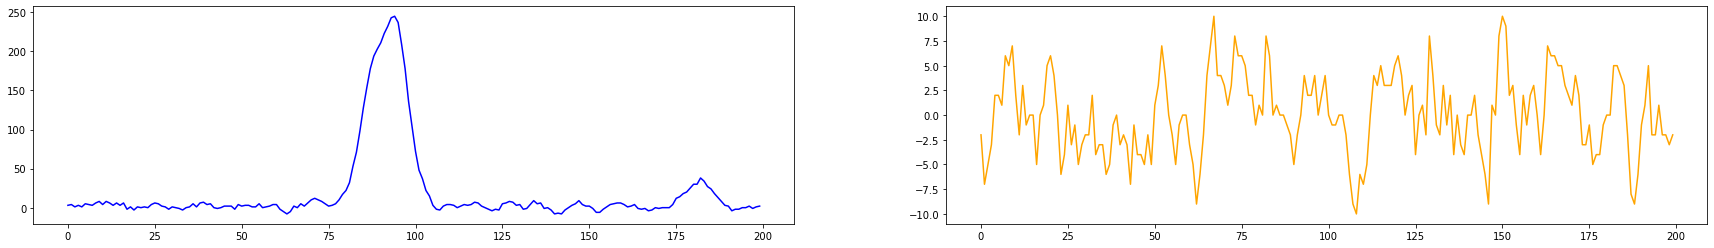

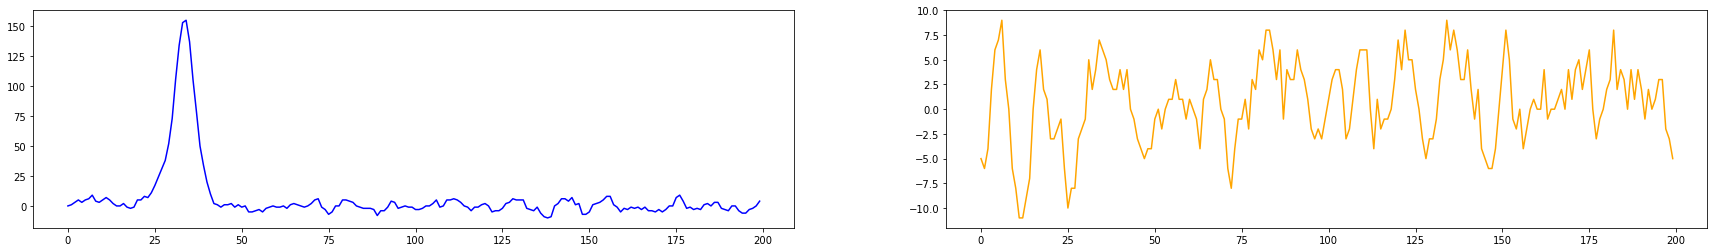

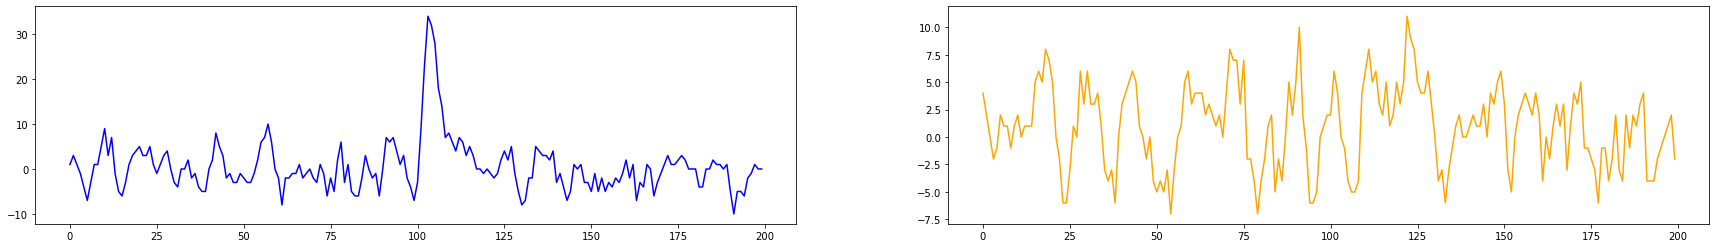

In [6]:
for idx in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 4))
    ax1.plot(signal_waveforms[idx], color='blue')

    ax2.plot(noise_waveforms[idx], color='orange')
    plt.show()

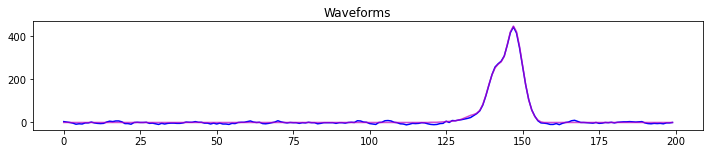

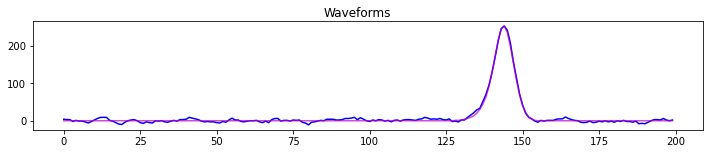

In [7]:
num = 0
for idx in range(num,num+2):
    fig, (ax1) = plt.subplots(figsize=(12, 2))
    fig.suptitle('Waveforms')
    ax1.plot(signal_waveforms[idx],color='blue', label='clean')
    ax1.plot(clean_signal_waveforms[idx],color='m',alpha=0.7, label='data')
    plt.show()

In [8]:
#generate y data (assuming all radiologicals contain signal, all noise does not)
y_noise_full_ROI = np.zeros(noise_waveforms.shape[0])  # for 1dcnn
y_signal_ROI = np.ones(signal_waveforms.shape[0])      # for 1dcnn
y_test_signal_ROI = np.ones(test_signal_waveforms.shape[0])  # for 1dcnn

# split test and train noise datasets (50k)
x_noise_train, x_noise_test, y_noise_train_ROI, y_noise_test_ROI, y_noise_train_AE, y_noise_test_AE = train_test_split(
    noise_waveforms, y_noise_full_ROI, noiseless_waveform, test_size=0.5, shuffle=True
)

#Shuffle signal waveforms to be safe
signal_waveforms, y_signal_RIO, y_signal_AE = shuffle(signal_waveforms,y_signal_ROI, clean_signal_waveforms)

x_test, y_test_ROI, y_test_AE = shuffle(test_signal_waveforms, y_test_signal_ROI, test_clean_waveforms)

In [9]:
print(x_noise_train.shape, signal_waveforms.shape, x_test.shape)

(50000, 200) (69749, 200) (70114, 200)


In [10]:
print(x_test.shape, y_test_ROI.shape)

(70114, 200) (70114,)


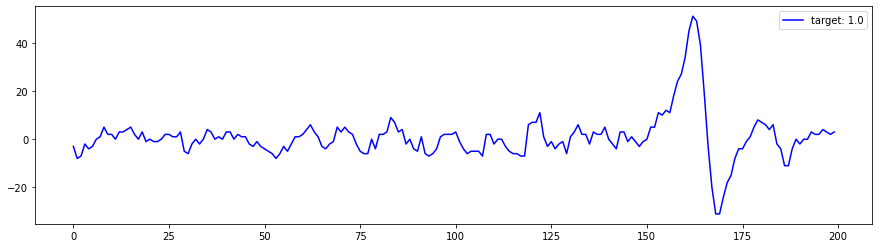

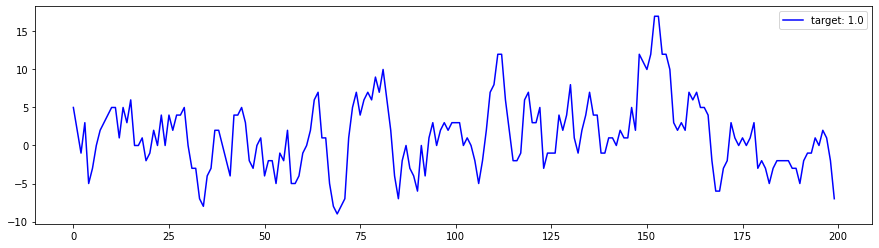

In [11]:
for idx in range(14205-2, 14205):
    fig, (ax1) = plt.subplots(figsize=(15, 4))
    ax1.plot(signal_waveforms[idx], color='blue', label= "target: " + str(y_signal_ROI[idx]))
    ax1.legend()
    plt.show()

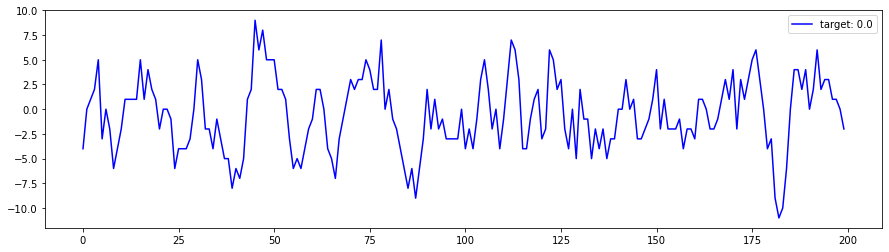

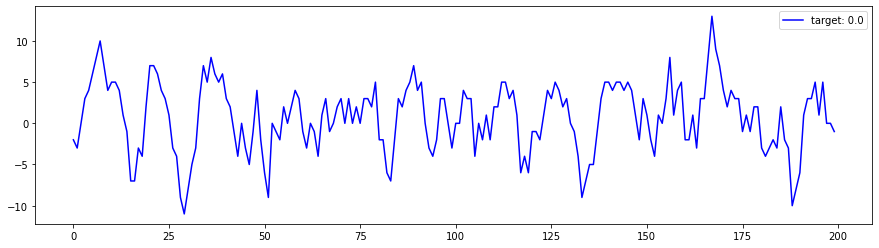

In [12]:
for idx in range(2):
    fig, (ax1) = plt.subplots(figsize=(15, 4))
    ax1.plot(x_noise_train[idx], color='blue', label= "target: " + str(y_noise_train_ROI[idx]))
    ax1.legend()
    plt.show()

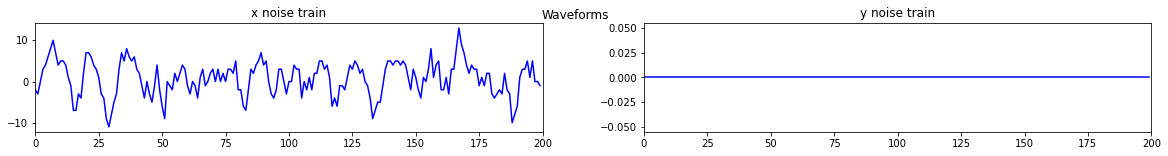

In [13]:
start_for_plot = 0
idx = 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 2))
fig.suptitle('Waveforms')
ax1.plot(x_noise_train[idx],color='blue')
ax1.set_xlim(start_for_plot, start_for_plot + 200)
ax1.set_title("x noise train")

ax2.plot(y_noise_train_AE[idx],color='blue')
ax2.set_xlim(start_for_plot, start_for_plot + 200)
ax2.set_title("y noise train")

plt.show()

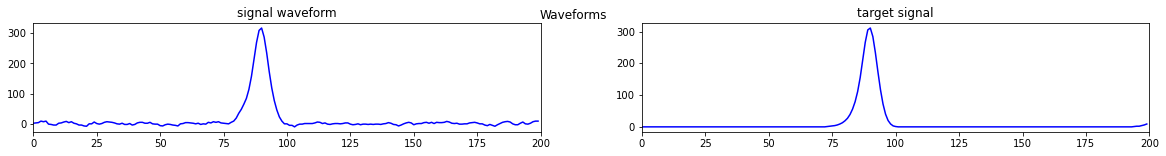

In [14]:
start_for_plot = 0
idx = 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 2))
fig.suptitle('Waveforms')
ax1.plot(signal_waveforms[idx],color='blue')
ax1.set_xlim(start_for_plot, start_for_plot + 200)
ax1.set_title("signal waveform")

ax2.plot(y_signal_AE[idx],color='blue')
ax2.set_xlim(start_for_plot, start_for_plot + 200)
ax2.set_title("target signal")

plt.show()

In [15]:
#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced train set 
x_train = np.concatenate((signal_waveforms[:int(x_noise_train.shape[0])], x_noise_train))
y_train_ROI = np.concatenate((y_signal_RIO[:int(x_noise_train.shape[0])], y_noise_train_ROI))
y_train_AE = np.concatenate((y_signal_AE[:int(x_noise_train.shape[0])], y_noise_train_AE))


x_test = np.concatenate((x_test[:int(x_noise_test.shape[0])], x_noise_test))
y_test_ROI = np.concatenate((y_test_signal_ROI[:int(x_noise_test.shape[0])], y_noise_test_ROI))
y_test_AE = np.concatenate((y_test_AE[:int(x_noise_test.shape[0])], y_noise_test_AE))


# extra train shuffle for good measure 
x_train, y_train_ROI, y_train_AE = shuffle(x_train,y_train_ROI, y_train_AE)
# extra test shuffle for good measure 
x_test, y_test_ROI, y_test_AE = shuffle(x_test,y_test_ROI, y_test_AE)


In [16]:
print(x_train.shape, y_train_ROI.shape, x_test.shape, y_test_ROI.shape)

(100000, 200) (100000,) (100000, 200) (100000,)


In [17]:
#print(x_train.shape, y_train.shape)
print(x_test.shape, y_test_AE.shape)

(100000, 200) (100000, 200)


In [18]:
mean = x_train.mean()
std = x_train.std()

In [19]:
np.save("processed_data/mean_" + wireplane, mean)
np.save("processed_data/std_" + wireplane, std)

In [20]:
np.save("processed_data/x_train_" + wireplane, x_train)
np.save("processed_data/x_test_" + wireplane, x_test)
np.save("processed_data/y_train_ROI_" + wireplane, y_train_ROI)
np.save("processed_data/y_train_AE_" + wireplane, y_train_AE)
np.save("processed_data/y_test_ROI_" + wireplane, y_test_ROI)
np.save("processed_data/y_test_AE_" + wireplane, y_test_AE)
